# Предсказание показаний состояния пациента

### Данные
Данные в файле covid_flow.pkl включают поток пациентов с подтвержденным COVID-19 в ковидные стационары НИМЦ
Алмазова, Санкт-Петербург.

Датасет включает 1992 случая стационарного лечения COVID-19. Данные включают

Многомерные временные ряды, описывающие состояние пациента (интервал неделя)
План лечения (препараты и процедуры) для каждого пациента
Исходы лечения

### Переменные 
_stat_control – стационарные признаки, которые описывают контролирующий
процесс и не меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 препарата в план лечения)

_dinam_control – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 процедуры в план лечения)

_stat_fact – стационарные признаки, которые описывают контролируемый процесс
и не меняются (в covid_flow это признаки, описывающие пациентов, пол, возраст, и
все остальное что не меняется)

_dinam_fact – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это признаки описывающие состояние
пациентов, например температура, % поражения легких и другое)

t_point – индикатор временного интервала. Вся длительность процесса разбита на
равные интервалы времени, t_point – метка интервала.

end_epizode – индикатор конца процесса, 0 – процесс лечения не окончен в
данном t_point, 1 – окончен

case (index) – уникальный идентификатор наблюдения (процесса), пример –
«GACAk+Q»

long_observation_tar – длинна процесса

current_process_duration – текущая длинна процесса (на момент t_point)

outcome_tar – исход лечения, 1- летальный, 0 – выздоровление.

### Задача
Прогноз значения индикаторов состояния пациента (результаты анализов)

Таргеты – признаки с префиксами _dinam_fact.
Факторы – предыдущие значения (кроме _tar), текущее состояние

На выходе получаем класс, который умеет принимать информацию о прошлых состояниях пациента, и прогнозировать следующее.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Input
from keras import Model
from keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

### Load data

In [51]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df.set_index(["case", "t_point"], inplace=True)
df = df.sort_values(["case", "t_point"])

In [27]:
df.iloc[:, 43:47]

трансфузия_dinam_control  оксигенотерапия_dinam_control  \
case    t_point                                                            
GACAAcY 0                               0                              1   
        1                               0                              1   
        2                               0                              1   
        3                               0                              1   
GACAAnf 0                               0                              0   
...                                   ...                            ...   
GACBB;O 0                               0                              0   
        1                               0                              0   
GACXAAB 0                               0                              0   
        1                               0                              0   
        2                               0                              0   

                 НИВЛ_dinam_control  ИВЛ_dinam_control  
case    t_point                                         
GACAAcY 0                         0                  0  
        1                         0                  0  
        2                         0                  0  
        3                         0                  0  
GACAAnf 0                         0                  0  
...                             ...                ...  
GACBB;O 0                         0                  0  
        1                         0                  0  
GACXAAB 0                         0                  0  
        1                         0                  0  
        2                         0                  0  

[6188 rows x 4 columns]

# Predict next period by last one

In [8]:
dinam_fact_df = df.iloc[:,29:42]
dinam_fact_df = dinam_fact_df.sort_values(["case", "t_point"])
dinam_fact_df

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                          36.7                   1.93   
        1                          36.3                   2.00   
        2                          36.6                   2.13   
        3                          36.5                   2.12   
GACAAnf 0                           NaN                   1.21   
...                                 ...                    ...   
GACBB;O 0                          36.9                   1.22   
        1                          36.5                   1.65   
GACXAAB 0                          36.5                   1.11   
        1                          36.9                   1.60   
        2                          36.6                   3.45   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0                 27.90            74.0            24.0   
        1                 25.70            71.0            19.0   
        2                 32.00             NaN            18.0   
        3                 27.00            71.0            18.0   
GACAAnf 0                 20.70            55.0            22.0   
...                         ...             ...             ...   
GACBB;O 0                 22.34            54.0            18.0   
        1                244.03             NaN            17.0   
GACXAAB 0                 21.80             NaN             NaN   
        1                 60.80            75.0            16.0   
        2                 17.20             NaN            15.0   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                             15.30   
        1                             12.10   
        2                               NaN   
        3                               NaN   
GACAAnf 0                              7.80   
...                                     ...   
GACBB;O 0                              1.43   
        1                              3.78   
GACXAAB 0                              4.50   
        1                              1.10   
        2                              9.30   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                           11.2   
        1                                           10.6   
        2                                           11.0   
        3                                           11.4   
GACAAnf 0                                            8.1   
...                                                  ...   
GACBB;O 0                                            7.0   
        1                                            7.2   
GACXAAB 0                                           10.6   
        1                                           10.8   
        2                                           10.0   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                             0.100                   48.3   
        1                             0.160                   30.7   
        2                             0.190                   23.1   
        3                             0.100                   24.1   
GACAAnf 0                             0.201                   24.1   
...                                     ...                    ...   
GACBB;O 0                             0.134                   33.0   
        1                             0.210                   41.2   
GACXAAB 0                             0.200                   18.8   
        1                             0.270                   12.9   
        2                             0.280          

### Data preparation 

Our suggestion is to divide history by 3 periods

Count of patients: 1992


<AxesSubplot: >

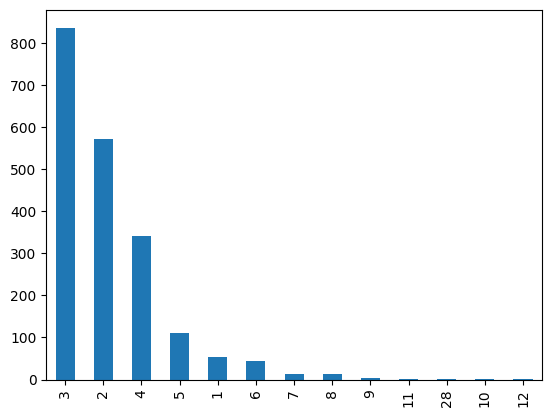

In [11]:
print(f"Count of patients: {dinam_fact_df.index.levels[0].size}")
dinam_fact_df.groupby(["case"]).size().value_counts(sort=True).plot(kind="bar")

#### Scaling and imputing

Scale values as (x-min(x))/(max(x)-min(x))

Impute NaN values using MICE method with IterativeImputer on Linear regression as estimator 

In [9]:
columns, index = dinam_fact_df.columns, dinam_fact_df.index

scal_model = MinMaxScaler()
scal_model = scal_model.fit(dinam_fact_df)
pickle.dump(scal_model.__getstate__(), open("models/minmax_scaler.pkl", 'wb'))
df_scaled = scal_model.transform(dinam_fact_df)

# TBD: need experiments
imp = IterativeImputer(estimator=LinearRegression(),
     missing_values=np.nan, max_iter=10, imputation_order='roman')
imp = imp.fit(df_scaled)
pickle.dump(imp.__getstate__(), open("models/iterative_imputer.pkl", 'wb'))
df_imputed = imp.transform(df_scaled)

dinam_fact_df = pd.DataFrame(data=df_imputed, columns = columns, index = index)
dinam_fact_df

d:\covid\covid\venv\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                      0.354167               0.012409   
        1                      0.270833               0.012896   
        2                      0.333333               0.013803   
        3                      0.312500               0.013733   
GACAAnf 0                      0.354510               0.007389   
...                                 ...                    ...   
GACBB;O 0                      0.395833               0.007459   
        1                      0.312500               0.010457   
GACXAAB 0                      0.312500               0.006692   
        1                      0.395833               0.010108   
        2                      0.333333               0.023005   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0              0.012004        0.496644        0.125000   
        1              0.011022        0.476510        0.093750   
        2              0.013833        0.481220        0.087500   
        3              0.011602        0.476510        0.087500   
GACAAnf 0              0.008791        0.369128        0.112500   
...                         ...             ...             ...   
GACBB;O 0              0.009523        0.362416        0.087500   
        1              0.108447        0.465736        0.081250   
GACXAAB 0              0.009282        0.466296        0.098837   
        1              0.026685        0.503356        0.075000   
        2              0.007229        0.490074        0.068750   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                          0.118339   
        1                          0.093260   
        2                          0.080601   
        3                          0.087013   
GACAAnf 0                          0.059561   
...                                     ...   
GACBB;O 0                          0.009639   
        1                          0.028056   
GACXAAB 0                          0.033699   
        1                          0.007053   
        2                          0.071317   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                       0.578125   
        1                                       0.531250   
        2                                       0.562500   
        3                                       0.593750   
GACAAnf 0                                       0.335938   
...                                                  ...   
GACBB;O 0                                       0.250000   
        1                                       0.265625   
GACXAAB 0                                       0.531250   
        1                                       0.546875   
        2                                       0.484375   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                          0.101604               0.497343   
        1                          0.165775               0.310308   
        2                          0.197861               0.229543   
        3                          0.101604               0.240170   
GACAAnf 0                          0.209626               0.240170   
...                                     ...                    ...   
GACBB;O 0                          0.137968               0.334750   
        1                          0.219251               0.421892   
GACXAAB 0                          0.208556               0.183847   
        1                          0.283422               0.121148   
        2                          0.294118          

In [60]:
def df_to_X_y(df, window=3):
    X, y = [], []
    df_grouped = df.groupby("case").size()
    df_idx = df_grouped[df_grouped==window+1].index #Select windows with size window
    for i in df_idx:
        X.append(df.loc[(i, 0): (i, window-1)].to_numpy())
        y.append(df.loc[(i, window)].to_numpy())
    return np.array(X), np.array(y)

X, y = df_to_X_y(dinam_fact_df, 3)
X.shape

(341, 3, 13)

Divide on train, test, validation splits

In [129]:
def split_train_test(X, y, test_size=0.2):   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=1/2)
    return (X_train, y_train), (X_test, y_test), (X_val, y_val)
(X_train, y_train), (X_test, y_test), (X_val, y_val) = split_train_test(X, y)
(X_test, y_test), (X_val, y_val) = (X_test[:-2], y_test[:-2]), (X_val[:-3], y_val[:-3])
print("TRAIN shape: ", X_train.shape)
print("TEST shape: ", y_test.shape)
print("VAL shape: ", y_val.shape)

TRAIN shape:  (272, 3, 13)
TEST shape:  (32, 13)
VAL shape:  (32, 13)


Summarize preparation function

## Training

#### Function which shows results of model

In [128]:
# Function which shows results of model
def show_results(X_test, y_test, model, history, batch_size=None, sample_num = 0):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["train loss", "validation loss"])

    y_pred = model.predict(X_test, batch_size=batch_size, verbose=0)

    r2_scor = r2_score(y_test, y_pred, multioutput="raw_values")
    mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")

    table=[]
    table.append(mse_score)
    table.append(r2_scor)

    df = pd.DataFrame(table, ["MSE", "R2"], columns=dinam_fact_df.columns)

    display(df)
    plt.show()
    

### One layer RNN size 13

Simple RNN with state units 13 and relu activation between layers and linear activation on last layer

Model: "RNN13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 13)                351       
                                                                 
 dense_93 (Dense)            (None, 13)                182       
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: models/minmax_scaler/RNN13\assets


INFO:tensorflow:Assets written to: models/minmax_scaler/RNN13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.003717,0.001817,0.001314,0.014554,0.00224,0.002075,0.008877,0.008000,0.011139,0.003297,0.056560,0.003283,0.005360
R2,-5.996868,-107.952834,-19.087850,-0.245330,-14.84687,-0.207767,0.001986,0.070414,-1.072026,0.891078,-0.080554,-13.943281,0.167861


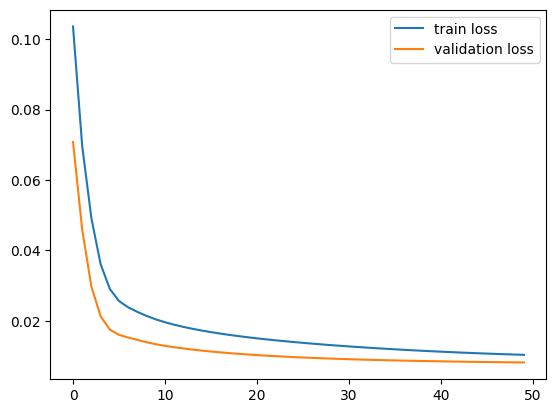

In [132]:
PARAMS_LENGTH = 13
WINDOW = 3
model = Sequential(name="RNN13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model_simple_rnn_13 = model
model_simple_rnn_13.compile(optimizer="adam", loss="mse")
model_simple_rnn_13.summary()
history = model_simple_rnn_13.fit(X_train, y_train,
 epochs=50, shuffle=False, validation_data=(X_val, y_val), verbose=0)
model_simple_rnn_13.save("models/minmax_scaler/RNN13")
show_results(X_test, y_test, model_simple_rnn_13, history)

RNN with sigmoid

INFO:tensorflow:Assets written to: models/minmax_scaler/RNN13_sigmoid\assets


INFO:tensorflow:Assets written to: models/minmax_scaler/RNN13_sigmoid\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000524,0.003852,0.003429,0.011834,0.000231,0.001704,0.009250,0.009872,0.005122,0.028582,0.052109,0.001796,0.006394
R2,0.013878,-229.986560,-51.429302,-0.012624,-0.630585,0.008164,-0.039996,-0.147065,0.047331,0.055884,0.004482,-7.175030,0.007252


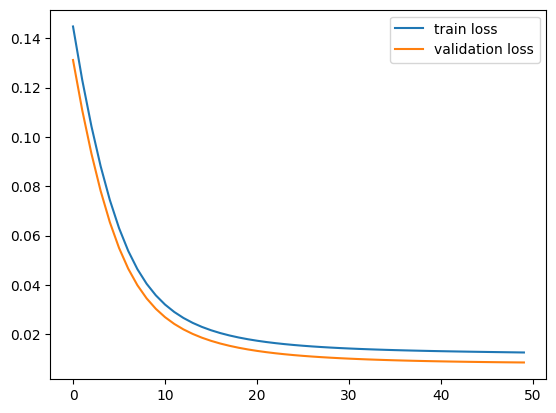

In [133]:
name = "RNN13_sigmoid"
model = Sequential(name=name)
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="sigmoid"))
model_simple_rnn_13 = model
model_simple_rnn_13.compile(optimizer="adam", loss="mse")

history = model_simple_rnn_13.fit(X_train, y_train,
 epochs=50, shuffle=False, validation_data=(X_val, y_val), verbose=0)
model_simple_rnn_13.save(f"models/{name}")

show_results(X_test, y_test, model_simple_rnn_13, history)

### LSTM

Model LSTM with 13 units as state

Model: "LSTM13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 13)                1404      
                                                                 
 dense_25 (Dense)            (None, 13)                182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: LSTM13\assets


INFO:tensorflow:Assets written to: LSTM13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
prev,36.745065,7.831741,89.586643,75.000000,24.000000,7.400000,8.300000,0.198415,39.745996,0.000000,2.000000,255.000000,16.600000
prev,36.606389,7.688827,80.785316,69.000000,19.000000,15.500000,8.100000,0.279060,26.901233,0.000000,5.000000,347.000000,20.900000
prev,36.622275,7.860323,91.928546,69.000000,22.000000,10.768488,7.700000,0.402658,24.746627,0.000000,5.000000,328.000000,20.600000
real,36.634984,8.212844,76.804532,78.000000,18.000000,11.450912,7.900000,0.279937,31.541921,0.000000,5.000000,251.000000,20.600000
predicted,36.540314,3.155257,61.755249,71.379005,15.612888,9.613486,9.258611,0.310690,37.886070,0.109091,4.693851,290.121033,16.906361
MSE,0.001496,0.000689,0.002431,0.003172,0.000473,0.017826,0.010777,0.004245,0.006081,0.008936,0.012462,0.002920,0.008065
R2,-0.245810,-46.947740,0.060228,0.022365,-1.671874,0.083095,-0.042206,-0.099420,0.129831,0.704818,-1.112789,-0.469532,0.389257


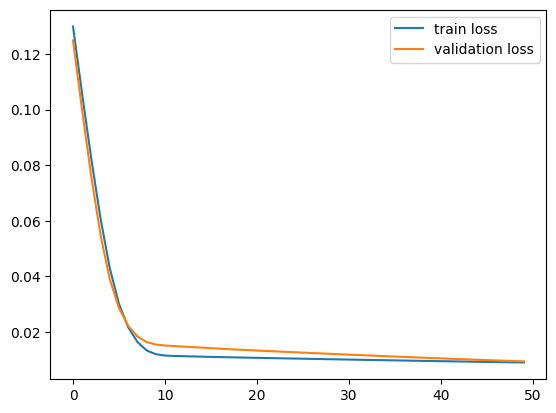

In [186]:
model = Sequential(name="LSTM13")
model.add(Input((3, PARAMS_LENGTH)))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model_lstm_13 = model
model_lstm_13.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_13.summary()
history = model_lstm_13.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val),
 shuffle=False, verbose=0)
model_lstm_13.save("LSTM13")
show_results(X_test, y_test, model_lstm_13, history)

#### LSTM with batch

Model: "LSTM13Batch12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (8, 13)                   1404      
                                                                 
 dense_97 (Dense)            (8, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: LSTM13Batch12\assets


INFO:tensorflow:Assets written to: LSTM13Batch12\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000904,0.000065,0.000835,0.012824,0.000197,0.002340,0.007111,0.007547,0.003912,0.00070,0.056293,0.000910,0.006087
R2,-0.701048,-2.899103,-11.764621,-0.097326,-0.392295,-0.362134,0.200501,0.123114,0.272407,0.97689,-0.075452,-3.140263,0.054961


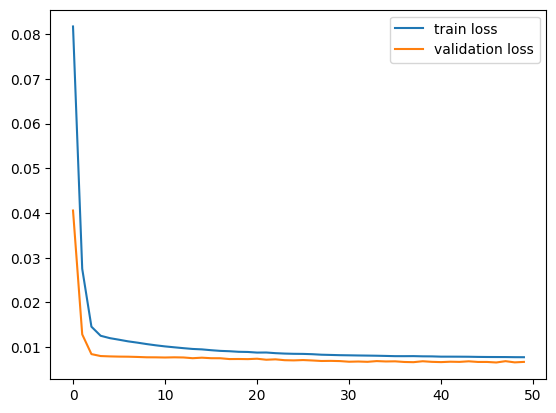

In [136]:
BATCH_SIZE=8
name = "LSTM13Batch12"
model = Sequential(name=name)
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model_lstm_13_b12 = model
model_lstm_13_b12.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_13_b12.summary()
history = model_lstm_13_b12.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
model_lstm_13.save(name)
show_results(X_test, y_test, model_lstm_13_b12, history, batch_size=BATCH_SIZE)

#### LSTM64 Encoder + LSTM 13 Decoder 

Model: "LSTM64xLSTM13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 3, 64)             19968     
                                                                 
 lstm_50 (LSTM)              (None, 13)                4056      
                                                                 
 dense_98 (Dense)            (None, 13)                182       
                                                                 
Total params: 24,206
Trainable params: 24,206
Non-trainable params: 0
_________________________________________________________________
None


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001786,0.000405,0.000852,0.013041,0.000281,0.002475,0.006555,0.009207,0.004669,0.000774,0.058032,0.001242,0.005782
R2,-2.363042,-23.279954,-12.029037,-0.115850,-0.989805,-0.440692,0.263070,-0.069818,0.131455,0.974436,-0.108665,-4.651790,0.102278


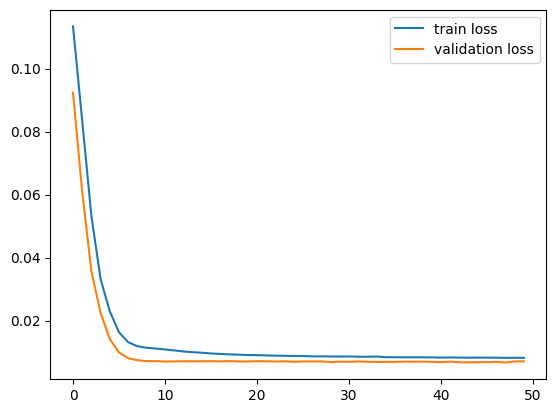

In [137]:

model = Sequential(name="LSTM64xLSTM13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model_lstm_64_encod = model
model_lstm_64_encod.compile(optimizer="adam", loss="mse")
print(model_lstm_64_encod.summary())
history = model_lstm_64_encod.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), verbose=0)

show_results(X_test, y_test, model_lstm_64_encod, history, batch_size=BATCH_SIZE)

Model: "LSTM13Batch12Tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (8, 13)                   1404      
                                                                 
 dense_28 (Dense)            (8, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: LSTM13Batch12Tanh\assets


INFO:tensorflow:Assets written to: LSTM13Batch12Tanh\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
prev,36.745065,7.831741,89.586643,75.000000,24.000000,7.400000,8.300000,0.198415,39.745996,0.000000,2.000000,255.000000,16.600000
prev,36.606389,7.688827,80.785316,69.000000,19.000000,15.500000,8.100000,0.279060,26.901233,0.000000,5.000000,347.000000,20.900000
prev,36.622275,7.860323,91.928546,69.000000,22.000000,10.768488,7.700000,0.402658,24.746627,0.000000,5.000000,328.000000,20.600000
real,36.634984,8.212844,76.804532,78.000000,18.000000,11.450912,7.900000,0.279937,31.541921,0.000000,5.000000,251.000000,20.600000
predicted,36.633213,8.621144,80.751366,74.755417,17.713295,9.488062,7.907851,0.303713,37.309494,0.043941,4.646734,297.829163,17.694330
MSE,0.001550,0.000017,0.003382,0.002821,0.000642,0.018131,0.006019,0.003696,0.005034,0.001337,0.010389,0.003058,0.006322
R2,-0.290246,-0.163703,-0.307005,0.130391,-2.625944,0.067420,0.417943,0.042779,0.279528,0.955850,-0.761331,-0.538785,0.521286


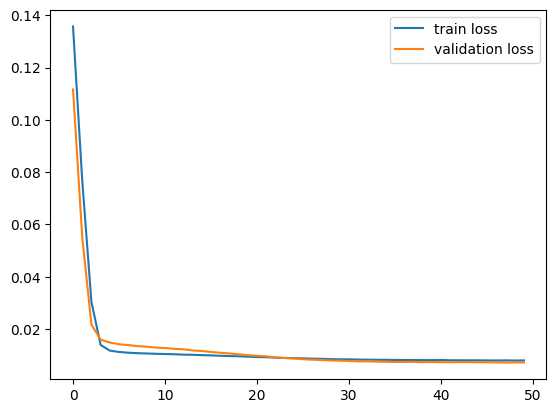

In [189]:
name = "LSTM13Batch12Tanh"
model = Sequential(name=name)
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="tanh"))
model_lstm_13_b12 = model
model_lstm_13_b12.compile(optimizer="adam", loss="mse")
model_lstm_13_b12.summary()
history = model_lstm_13_b12.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
model_lstm_13.save(name)
show_results(X_test, y_test, model_lstm_13_b12, history, batch_size=BATCH_SIZE)

## Train with static parameters


Lets define new function for splitting

In [52]:
df.iloc[:, 29:43]

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                          36.7                   1.93   
        1                          36.3                   2.00   
        2                          36.6                   2.13   
        3                          36.5                   2.12   
GACAAnf 0                           NaN                   1.21   
...                                 ...                    ...   
GACBB;O 0                          36.9                   1.22   
        1                          36.5                   1.65   
GACXAAB 0                          36.5                   1.11   
        1                          36.9                   1.60   
        2                          36.6                   3.45   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0                 27.90            74.0            24.0   
        1                 25.70            71.0            19.0   
        2                 32.00             NaN            18.0   
        3                 27.00            71.0            18.0   
GACAAnf 0                 20.70            55.0            22.0   
...                         ...             ...             ...   
GACBB;O 0                 22.34            54.0            18.0   
        1                244.03             NaN            17.0   
GACXAAB 0                 21.80             NaN             NaN   
        1                 60.80            75.0            16.0   
        2                 17.20             NaN            15.0   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                             15.30   
        1                             12.10   
        2                               NaN   
        3                               NaN   
GACAAnf 0                              7.80   
...                                     ...   
GACBB;O 0                              1.43   
        1                              3.78   
GACXAAB 0                              4.50   
        1                              1.10   
        2                              9.30   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                           11.2   
        1                                           10.6   
        2                                           11.0   
        3                                           11.4   
GACAAnf 0                                            8.1   
...                                                  ...   
GACBB;O 0                                            7.0   
        1                                            7.2   
GACXAAB 0                                           10.6   
        1                                           10.8   
        2                                           10.0   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                             0.100                   48.3   
        1                             0.160                   30.7   
        2                             0.190                   23.1   
        3                             0.100                   24.1   
GACAAnf 0                             0.201                   24.1   
...                                     ...                    ...   
GACBB;O 0                             0.134                   33.0   
        1                             0.210                   41.2   
GACXAAB 0                             0.200                   18.8   
        1                             0.270                   12.9   
        2                             0.280          

In [140]:
def prepare_data_with_static(df_input, window=3, test_size=0.2):
    X, y = [], []
    df = df_input.copy()
    df_grouped = df.groupby(["case"]).size()
    df_idx = df_grouped[df_grouped==window+1].index
    scal_model = MinMaxScaler()
    df_scaled = scal_model.fit_transform(df.iloc[:, 29:43])
    imputer = IterativeImputer()
    df_imputed = imputer.fit_transform(df_scaled)
    df.iloc[:, 29:43] = df_imputed
    for i in df_idx:
        wind = df.loc[(i, 0): (i, window-1)]
        X.append(wind.iloc[:, :47])
        y.append(df.loc[(i, window)].iloc[29:42])
    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=1/2)
    return (X_train, y_train), (X_test, y_test), (X_val, y_val)

(X_train, y_train), (X_test, y_test), (X_val, y_val) = prepare_data_with_static(df, window=3)

In [54]:
print(X_train.shape,
X_val.shape,
X_test.shape)
print(y_train.shape,
y_val.shape,
y_test.shape)

(272, 3, 47) (35, 3, 47) (34, 3, 47)
(272, 13) (35, 13) (34, 13)


Model: "LSTMStatDynam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 128)               90112     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 13)                1677      
                                                                 
Total params: 91,789
Trainable params: 91,789
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
9/9 [==============================] - 2s 48ms/step - loss: 0.0961 - val_loss: 0.0375
Epoch 2/30
9/9 [==============================] - 0s 9ms/step - loss: 0.0375 - val_loss: 0.0305
Epoch 3/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0263 - val_loss: 0.0247
Epoch 4/30
9/9 [========

INFO:tensorflow:Assets written to: /models/ LSTMStatDynam\assets


INFO:tensorflow:Assets written to: /models/ LSTMStatDynam\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002084,0.000130,0.000567,0.015173,0.000244,0.003998,0.009084,0.009320,0.009349,0.041786,0.035513,0.000756,0.003933
R2,-0.508129,-2.415198,-1.515006,-0.311524,-0.267575,-0.654354,0.137731,-0.102064,0.062685,0.480594,-0.543328,-0.805222,0.426956


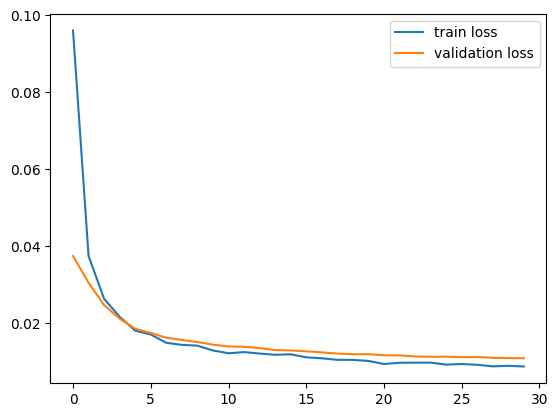

In [61]:
PARAMS_LENGTH = X_train.shape[2]
TARGET_LENGTH = y_train.shape[1]
WINDOW=3
name = "LSTMStatDynam"
model = Sequential(name=name)
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model_lstm = model
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.summary()
history = model_lstm.fit(X_train, y_train,
 epochs=30, validation_data=(X_val, y_val))
model_lstm_13.save("/models/ "+name)
show_results(X_test, y_test, model_lstm, history)

Here we will take dynamic and static params aparted

In [141]:
D_train = X_train[:, :, 29:]
S_train = X_train[:, 0, 0:29]
S_train = np.hstack([S_train, X_train[:, 0, 42:43]])
D_val = X_val[:, :, 29:]
S_val = X_val[:, 0, :29]
S_val = np.hstack([S_val, X_val[:, 0, 42:43]])


Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_74 (InputLayer)          [(None, 3, 18)]      0           []                               
                                                                                                  
 input_73 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 lstm_44 (LSTM)                 (None, 40)           9440        ['input_74[0][0]']               
                                                                                                  
 dense_86 (Dense)               (None, 16)           496         ['input_73[0][0]']               
                                                                                           

INFO:tensorflow:Assets written to: models/Dynamic_concat_Static\assets


INFO:tensorflow:Assets written to: models/Dynamic_concat_Static\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.008362,0.002818,0.001719,0.031421,0.001798,0.004556,0.012994,0.009675,0.008826,0.034057,0.040114,0.005298,0.009864
R2,-1.099588,-96.580435,-3.653329,-0.446320,-5.247576,-0.453766,-0.317777,-0.882591,-0.279925,0.721865,-0.174475,-1.351750,0.068850


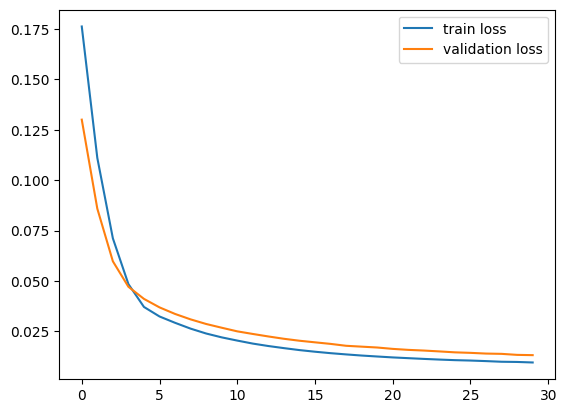

In [125]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
WINDOW=3
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(40, return_state=False)(input_dinamic)
result_layer = Dense(13, activation='linear')(concatenate([lstm_layer, dense_layer]))
model_multi = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi.summary()
model_multi.compile(optimizer="adam", loss="mse")

history = model_multi.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=30)
model_multi.save("models/Dynamic_concat_Static")

show_results([S_val, D_val], y_val, model_multi, history)

Lets use linear activation to compare results

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_76 (InputLayer)          [(None, 3, 18)]      0           []                               
                                                                                                  
 input_75 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 lstm_45 (LSTM)                 (None, 64)           21248       ['input_76[0][0]']               
                                                                                                  
 dense_88 (Dense)               (None, 32)           992         ['input_75[0][0]']               
                                                                                           

INFO:tensorflow:Assets written to: models/Dynamic_concat_Static\assets


INFO:tensorflow:Assets written to: models/Dynamic_concat_Static\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.006392,0.001143,0.002888,0.029426,0.000944,0.004438,0.006402,0.004968,0.006533,0.032033,0.035690,0.005053,0.007041
R2,-0.605015,-38.591081,-6.818193,-0.354485,-2.279437,-0.416060,0.350784,0.033256,0.052623,0.738401,-0.044947,-1.243180,0.335299


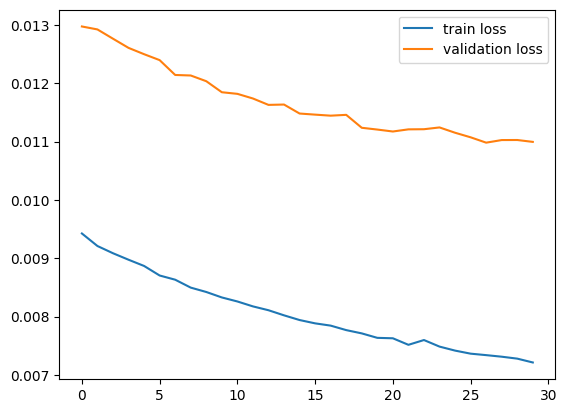

In [126]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
WINDOW=3
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(32, activation='relu')(input_static)
lstm_layer = LSTM(64, return_state=False)(input_dinamic)
result_layer = Dense(32, activation="relu")(concatenate([lstm_layer, dense_layer]))
result_layer = Dense(13, activation='linear')(result_layer)
model_multi_s3 = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi_s3.summary()
model_multi_s3.compile(optimizer="adam", loss="mse")

history = model_multi.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=30)
model_multi.save("models/Dynamic_concat_Static")

show_results([S_val, D_val], y_val, model_multi, history)

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_90 (InputLayer)          [(None, 3, 18)]      0           []                               
                                                                                                  
 input_89 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 gru_1 (GRU)                    (None, 64)           16128       ['input_90[0][0]']               
                                                                                                  
 dense_106 (Dense)              (None, 32)           992         ['input_89[0][0]']               
                                                                                           

INFO:tensorflow:Assets written to: models/Dynamic_concat_Static\assets


INFO:tensorflow:Assets written to: models/Dynamic_concat_Static\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.003098,0.000540,0.001018,0.007668,0.000481,0.002024,0.007557,0.003595,0.010328,0.029033,0.043052,0.001477,0.006550
R2,-4.117172,-10.359027,-3.695768,0.042890,-1.265280,0.270198,0.122750,-0.033538,-0.036776,0.629523,0.027684,-2.261450,0.382402


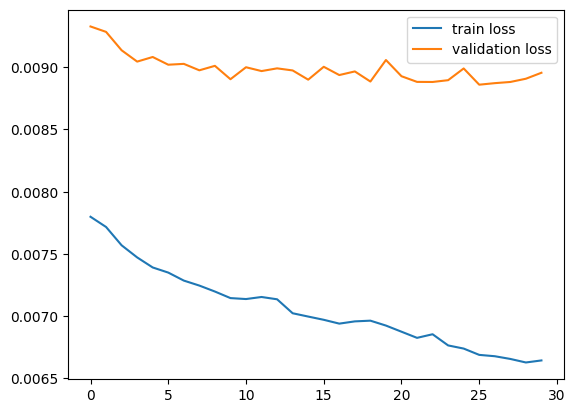

In [142]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
WINDOW=3
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(32, activation='relu')(input_static)
lstm_layer = GRU(64, return_state=False)(input_dinamic)
result_layer = Dense(32, activation="relu")(concatenate([lstm_layer, dense_layer]))
result_layer = Dense(13, activation='linear')(result_layer)
model_multi_s3 = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi_s3.summary()
model_multi_s3.compile(optimizer="adam", loss="mse")

history = model_multi.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=30)
model_multi.save("models/Dynamic_concat_Static")

show_results([S_val, D_val], y_val, model_multi, history)

## Dynamic windows

#### Window size: 1

In [149]:
df.loc[0:2, :]

омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  ...  \
case    t_point                                                   ...   
GACAAcY 0                             1                        1  ...   
        1                             1                        1  ...   

                 трансфузия_dinam_control  оксигенотерапия_dinam_control  \
case    t_point                                                            
GACAAcY 0                               0                              1   
        1                               0                              1   

                 НИВЛ_dinam_control  ИВЛ_dinam_control  long_observation_tar  \
case    t_point                                                                
GACAAcY 0                         0                  0                    22   
        1                         0                  0                    22   

                 outcome_tar  process_stages  current_process_duration  \
case    t_point                                                          
GACAAcY 0                  0               2                         3   
        1                  0               2                        10   

                 admission_date  end_epizode  
case    t_point                               
GACAAcY 0            2021-01-29            0  
        1            2021-01-29            0  

[2 rows x 53 columns]

In [178]:
def prepare_data_with_dynamic_window(df_input, window=1, test_size=0.2):
    X, y = [], []
    df = df_input.copy()
    df_grouped = df.groupby(["case"]).size()
    df_idx = df_grouped[df_grouped>=window+1].index
    scal_model = MinMaxScaler()
    df_scaled = scal_model.fit_transform(df.iloc[:, 29:43])
    imputer = IterativeImputer()
    df_imputed = imputer.fit_transform(df_scaled)
    df.iloc[:, 29:43] = df_imputed
    for i in df_idx:
        for j in range(len(df.loc[(i)])-window):
            wind = df.loc[(i, j): (i, j+window-1)]
            X.append(wind.iloc[:, :47])
            y.append(df.loc[(i, j+window)].iloc[29:42])
    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=1/2)
    return (X_train, y_train), (X_test, y_test), (X_val, y_val)

def divide_X_dynamic_static(X_train, X_test, X_val):
    D_train = X_train[:, :, 29:]
    S_train = X_train[:, 0, 0:29]
    S_train = np.hstack([S_train, X_train[:, 0, 42:43]])
    D_val = X_val[:, :, 29:]
    S_val = X_val[:, 0, :29]
    S_val = np.hstack([S_val, X_val[:, 0, 42:43]])
    D_test = X_test[:, :, 29:]
    S_test = X_test[:, 0, :29]
    S_test = np.hstack([S_test, X_test[:, 0, 42:43]])
    return D_train, S_train, D_val, S_val, D_test, S_test

(X_train, y_train), (X_test, y_test), (X_val, y_val) = prepare_data_with_dynamic_window(df, window=1)
D_train, S_train, D_val, S_val, D_test, S_test = divide_X_dynamic_static(X_train, X_test, X_val)
print(X_train.shape,
X_test.shape)

Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_106 (InputLayer)         [(None, 1, 18)]      0           []                               
                                                                                                  
 input_105 (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 lstm_60 (LSTM)                 (None, 40)           9440        ['input_106[0][0]']              
                                                                                                  
 dense_123 (Dense)              (None, 16)           496         ['input_105[0][0]']              
                                                                                           

INFO:tensorflow:Assets written to: models/Dynamic_concat_Static\assets


INFO:tensorflow:Assets written to: models/Dynamic_concat_Static\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001632,0.000107,0.000306,0.008148,0.000231,0.001463,0.016965,0.010216,0.017038,0.050725,0.081654,0.000809,0.013781
R2,-0.050671,-0.251061,-0.147669,-0.009387,-0.188224,-0.007064,-0.028914,-0.010507,-0.030449,-0.021908,-0.001895,-0.084522,-0.016004


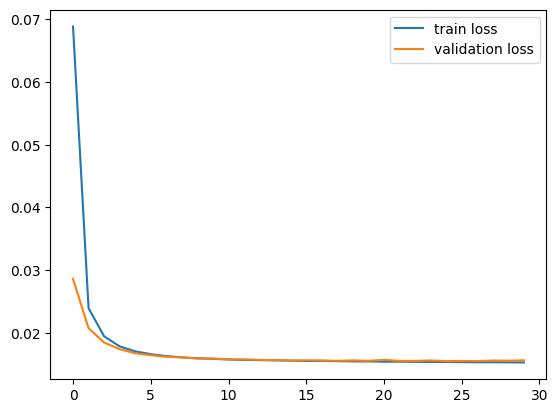

In [174]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
WINDOW=1
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(40, return_state=False)(input_dinamic)
result_layer = Dense(13, activation='linear')(concatenate([lstm_layer, dense_layer]))
model_multi = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi.summary()
model_multi.compile(optimizer="adam", loss="mse")

history = model_multi.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=30)
model_multi.save("models/Dynamic_concat_Static")

show_results([S_val, D_val], y_val, model_multi, history)

In [181]:
X_train.shape

(3356, 1, 47)

In [188]:
opt =model.predict(X_test)
opt.shape
#y_test.shape

14/14 [==============================] - 0s 3ms/step


(420, 1, 13)

Model: "LSTMStatDynam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 47)                0         
                                                                 
 dense_132 (Dense)           (None, 32)                1536      
                                                                 
 dense_133 (Dense)           (None, 13)                429       
                                                                 
Total params: 1,965
Trainable params: 1,965
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
105/105 [==============================] - 1s 7ms/step - loss: 0.1013 - val_loss: 0.0399
Epoch 2/30
105/105 [==============================] - 0s 3ms/step - loss: 0.0281 - val_loss: 0.0229
Epoch 3/30
105/105 [==============================] - 0s 4ms/step - loss: 0.0189 - val_loss: 0.0180
Epoch 4/30
105/

INFO:tensorflow:Assets written to: /models/ LSTMStatDynam\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001644,0.001733,0.000303,0.011129,0.000590,0.001175,0.006390,0.009690,0.009751,0.003015,0.073490,0.000750,0.005980
R2,-0.089842,0.207111,0.031599,-0.056593,0.037551,-0.172972,0.571854,0.220253,0.467975,0.944043,-0.022202,-0.031435,0.559514


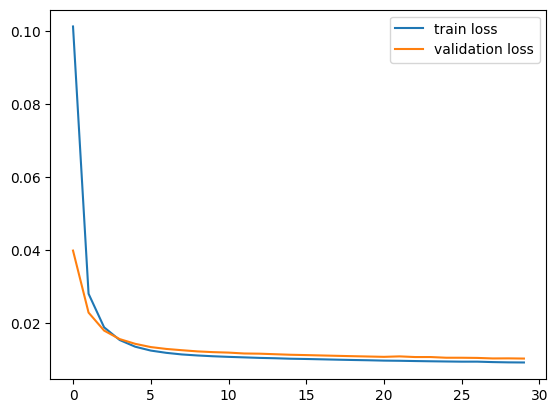

In [189]:
PARAMS_LENGTH = X_train.shape[2]
TARGET_LENGTH = y_train.shape[1]
WINDOW=1
name = "LSTMStatDynam"
model = Sequential(name=name)
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=30, validation_data=(X_val, y_val))
model.save("/models/ "+name)
show_results(X_test, y_test, model, history)

In [190]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = prepare_data_with_dynamic_window(df, window=2)
D_train, S_train, D_val, S_val, D_test, S_test = divide_X_dynamic_static(X_train, X_test, X_val)

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_113 (InputLayer)         [(None, 2, 18)]      0           []                               
                                                                                                  
 input_112 (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 lstm_62 (LSTM)                 (None, 40)           9440        ['input_113[0][0]']              
                                                                                                  
 dense_134 (Dense)              (None, 16)           496         ['input_112[0][0]']              
                                                                                           

INFO:tensorflow:Assets written to: models/Dynamic_concat_Static\assets


INFO:tensorflow:Assets written to: models/Dynamic_concat_Static\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000994,0.000609,0.004060,0.010411,0.000431,0.001786,0.007519,0.006124,0.006664,0.010106,0.046995,0.003538,0.005690
R2,-0.082594,0.845229,0.094531,0.009678,-0.077557,0.000259,0.478164,0.269983,0.618137,0.813595,0.039572,0.106861,0.535175


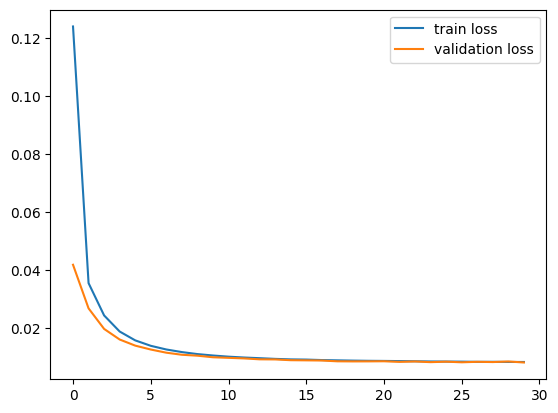

In [191]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
WINDOW=2
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(40, return_state=False)(input_dinamic)
result_layer = Dense(13, activation='linear')(concatenate([lstm_layer, dense_layer]))
model_multi = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi.summary()
model_multi.compile(optimizer="adam", loss="mse")

history = model_multi.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=30)
model_multi.save("models/Dynamic_concat_Static")

show_results([S_val, D_val], y_val, model_multi, history)

In [192]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = prepare_data_with_dynamic_window(df, window=3)
D_train, S_train, D_val, S_val, D_test, S_test = divide_X_dynamic_static(X_train, X_test, X_val)

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_102 (InputLayer)         [(None, 3, 18)]      0           []                               
                                                                                                  
 input_101 (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 lstm_57 (LSTM)                 (None, 40)           9440        ['input_102[0][0]']              
                                                                                                  
 dense_119 (Dense)              (None, 16)           496         ['input_101[0][0]']              
                                                                                           

INFO:tensorflow:Assets written to: models/Dynamic_concat_Static\assets


INFO:tensorflow:Assets written to: models/Dynamic_concat_Static\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002067,0.004127,0.000954,0.020760,0.002384,0.001521,0.008094,0.008000,0.014564,0.000689,0.056799,0.000683,0.006744
R2,-1.416342,0.570354,-2.045877,-0.122285,-8.648090,-0.058832,0.261522,-0.019106,0.426690,0.990492,-0.167740,-0.145391,0.512738


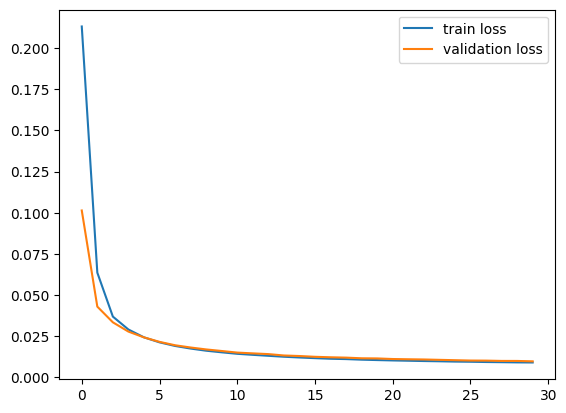

In [165]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
WINDOW=3
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(40, return_state=False)(input_dinamic)
result_layer = Dense(13, activation='linear')(concatenate([lstm_layer, dense_layer]))
model_multi = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi.summary()
model_multi.compile(optimizer="adam", loss="mse")

history = model_multi.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=30)
model_multi.save("models/Dynamic_concat_Static")

show_results([S_val, D_val], y_val, model_multi, history)

Model: "LSTMStatDynam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_65 (LSTM)              (None, 64)                28672     
                                                                 
 dense_138 (Dense)           (None, 13)                845       
                                                                 
Total params: 29,517
Trainable params: 29,517
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [==============================] - 3s 35ms/step - loss: 0.0698 - val_loss: 0.0259
Epoch 2/30
23/23 [==============================] - 0s 9ms/step - loss: 0.0233 - val_loss: 0.0158
Epoch 3/30
23/23 [==============================] - 0s 10ms/step - loss: 0.0171 - val_loss: 0.0131
Epoch 4/30
23/23 [==============================] - 0s 7ms/step - loss: 0.0148 - val_loss: 0.0120
Epoch 5/30
23/23 [==============================] -

INFO:tensorflow:Assets written to: /models/ LSTMStatDynam\assets


INFO:tensorflow:Assets written to: /models/ LSTMStatDynam\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001700,0.000390,0.001365,0.013889,0.000270,0.004800,0.006496,0.003936,0.008329,0.001609,0.064536,0.001057,0.005511
R2,-0.434228,-19.689567,-4.355020,-0.030099,-0.453182,0.223071,0.352891,0.207505,0.294860,0.974401,-0.163278,-1.107105,0.603446


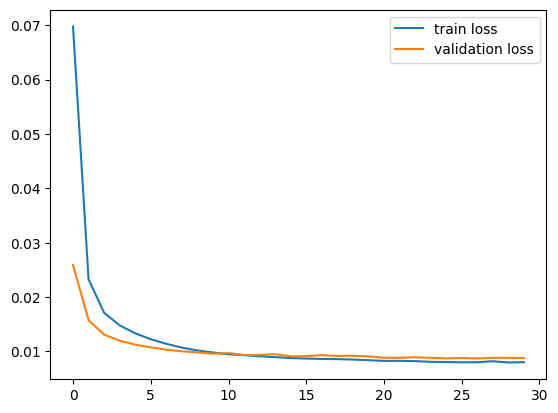

In [195]:
PARAMS_LENGTH = X_train.shape[2]
TARGET_LENGTH = y_train.shape[1]
WINDOW=3
name = "LSTMStatDynam"
model = Sequential(name=name)
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model_lstm = model
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.summary()
history = model_lstm.fit(X_train, y_train,
 epochs=30, validation_data=(X_val, y_val))
model_lstm_13.save("/models/ "+name)
show_results(X_test, y_test, model_lstm, history)